In [2]:
## use of external code

# this link helped us understand how to implement WGAN with gradient penalty, and after that DCGAN was easier to implement:
# https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py
# this link gave us an implementation of minibatch discrimination:
# https://github.com/sanghviyashiitb/GANS-VanillaAndMinibatchDiscrimination/blob/master/minibatch_discrimination.py
# this link gave us the implementation of the inception score:
# https://github.com/ChunyuanLI/MNIST_Inception_Score/blob/master/mnist_cnn_icp_eval.py

## mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## import libraries

import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import random
from glob import glob
import time
from scipy.stats import entropy

## settings

torch.manual_seed(6)
trainSetSize = 500
numOfChannels = 1 # only black and white
numOfLabels = 10
showImages = False
printProbabilities = False
showLossGraph = False
PrintInceptionScores = True
showInceptionScoreGraph = True
showModifiedInceptionScoreGraph = True
showFinalImagesOfBestGenerator = True
keepBestGenerator = True # currently the best one is the one with the best Inception score (not modified inception score)
saveBestGeneratorToFile = False # format is: {generator1_inception_3.456.pt, generator2_inception_4.4676.pt, ...} depending on number of configurations
classifierPath = F"/content/gdrive/My Drive/project_321089724_302363965/MNIST Inception Score/mnist_cnn2.pt"
saveModelPath = F"/content/gdrive/My Drive/project_321089724_302363965/trained_models/"
numberOfImagesForCalculationOfInceptionScore = 10000
numberOfEpochsBeforeCalculatingScores = 100

## hyper parameters

numOfDistributions = 30 # 30. should we try 50? or maybe 20?
batchSize = 100  # number of data points in each batch # 100
numOfEpochs = 5000  # times to run the model on complete data
latentDim = 30  # latent vector dimension # 30
generatorInitialLearningRateVec = [0.0005]   # 0.0005
discriminatorInitialLearningRateVec = [0.0002]  # 0.0002
firstEpochOfLearningRateDecayVec = [10000]
NumberOfEpochsBeforeNextDecayVec = [200]
sigmaRegulizerFactorVec = [0.1] #[0.1, 0, 5]
weightsOfGaussiansProbabilitiesVec = [np.ones(numOfDistributions)] #[np.flip(np.cumsum(np.ones(numOfDistributions))), np.ones(numOfDistributions)]
sigmaInitVec = [0.2] # maybe sigma = 0.2 is more apt than the the usual 0.9
outOfDiagonalSigmaInitVec = [0.001]
b1 = 0.5 # those are beta parameters of adamW
b2 = 0.999 # those are beta parameters of adamW
useMiniBatchDiscriminationVec = [True] # false
superDeLiGANVec = [False]
miniBatchDiscriminationBVec = [5] # 5
miniBatchDiscriminationCVec = [64] # 64
clipValueVec = [5] #[5, 0.3, 2] # 5

## start measuring time

initialTime = time.time()

## get GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

## a function for weighted random integers (used for non-uniformal probabilities for the GMM)
def nonUniformalRandomIntegers(weights=1,sizeOfOutput=1):
    weights = weights/np.sum(weights)
    cdf = np.cumsum(weights)
    rand01 = np.random.rand(sizeOfOutput)
    output = np.zeros_like(rand01)
    for indRand01,valueRand01 in enumerate(rand01):
      for indCdf, valueCdf in enumerate(cdf):
        output[indRand01] = len(weights)-1
        if valueRand01<valueCdf:
          output[indRand01] = indCdf
          break
    return output.astype(int)

## calculate inception scores

def calculateModifiedInceptionScore(preds):
    splits=10 			# the number of splits to average the score over
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    scores = []
    # Calculating the inception score
    for i in range(splits):
        part = preds[np.argmax(preds,axis=1)==i]
        logp = np.ma.log(part).data
        selfE = np.sum(part*logp,axis=1)
        cross = np.mean(np.dot(part,np.transpose(logp)),axis=1)
        diff = selfE - cross
        kl = np.mean(selfE - cross)
        scores.append(np.exp(kl))
    return scores

def calculateInceptionScore(preds):
  splits=10 			# the number of splits to average the score over
  classes = ["0","1","2","3","4","5","6","7","8","9"]
  scores = []
  # Calculating the inception score
  for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      py = np.mean(part, axis=0)
      kl = np.mean([entropy(part[i, :], py) for i in range(part.shape[0])])
      scores.append(np.exp(kl))
  return scores

## load MNSIT classifier

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

MNISTclassifier = Net().to(device)
filename = glob(classifierPath)[0]
MNISTclassifier.load_state_dict(torch.load(filename))


## here we loop over hyper parameters
configurationNumber = 0
for superDeLiGAN, useMiniBatchDiscrimination, clipValue, sigmaRegulizerFactor, generatorInitialLearningRate, discriminatorInitialLearningRate, \
   firstEpochOfLearningRateDecay, NumberOfEpochsBeforeNextDecay, weightsOfGaussiansProbabilities, sigmaInit, outOfDiagonalSigmaInit, \
   miniBatchDiscriminationB, miniBatchDiscriminationC in \
  itertools.product(superDeLiGANVec, useMiniBatchDiscriminationVec, clipValueVec, sigmaRegulizerFactorVec, generatorInitialLearningRateVec, \
    discriminatorInitialLearningRateVec, firstEpochOfLearningRateDecayVec, NumberOfEpochsBeforeNextDecayVec, weightsOfGaussiansProbabilitiesVec, \
    sigmaInitVec, outOfDiagonalSigmaInitVec, miniBatchDiscriminationBVec, miniBatchDiscriminationCVec):

    configurationStartTime = time.time()
    configurationNumber = configurationNumber + 1
    print(F"\nconfiguration number: {configurationNumber}\n")
    
    # here we print configuration details
    print(F"superDeLiGAN: {superDeLiGAN}\nuseMiniBatchDiscrimination: {useMiniBatchDiscrimination}\
    \nclipValue: {clipValue}\nsigmaRegulizerFactor: {sigmaRegulizerFactor}\ngeneratorInitialLearningRate: {generatorInitialLearningRate}\
    \ndiscriminatorInitialLearningRate: {discriminatorInitialLearningRate}\nfirstEpochOfLearningRateDecay {firstEpochOfLearningRateDecay}\
    \nNumberOfEpochsBeforeNextDecay: {NumberOfEpochsBeforeNextDecay}\nweightsOfGaussiansProbabilities: {weightsOfGaussiansProbabilities}\
    \nsigmaInit: {sigmaInit} \noutOfDiagonalSigmaInit: {outOfDiagonalSigmaInit}\nminiBatchDiscriminationB: {miniBatchDiscriminationB}\
    \nminiBatchDiscriminationC: {miniBatchDiscriminationC}\n")


    trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transforms.Compose([
                transforms.ToTensor()]))


    ## create a subset of the data

    samplesPerLabel = int(trainSetSize / numOfLabels)
    chosenIndices = list()
    for i in range(numOfLabels):
        chosenIndices += random.choices(np.where(trainset.targets == i)[0], k=samplesPerLabel)
    sampler = torch.utils.data.SubsetRandomSampler(chosenIndices)
    trainLoader = torch.utils.data.DataLoader(
        trainset, batch_size=batchSize, shuffle=False,
        sampler=SubsetRandomSampler(chosenIndices))


    class MiniBatchDiscrimination(nn.Module):
        def __init__(self, A, B, C, batch_size):
            super(MiniBatchDiscrimination, self).__init__()
            self.feat_num = A
            self.out_size = B
            self.row_size = C
            self.N = batch_size
            self.T = Parameter(torch.Tensor(A, B, C).to(device))
            self.reset_parameters()

        def forward(self, x):
            # Output matrices after matrix multiplication
            M = x.mm(self.T.view(self.feat_num, self.out_size * self.row_size)).view(-1, self.out_size, self.row_size)
            out = Variable(torch.zeros(self.N, self.out_size).to(device))
            for k in range(self.N):
                c = torch.exp(-torch.sum(torch.abs(M[k, :] - M), 2))  # exp(-L1 Norm of Rows difference)
                if k != 0 and k != self.N - 1:
                    out[k, :] = torch.sum(c[0:k, :], 0) + torch.sum(c[k+1:, :], 0)
                else:
                    if k == 0:
                        out[k, :] = torch.sum(c[1:, :], 0)
                    else:
                        out[k, :] = torch.sum(c[0:self.N - 1], 0)
            return out

        def reset_parameters(self):
            stddev = 1 / self.feat_num
            self.T.data.uniform_(stddev)


    ## define the net classes
    class Generator(torch.nn.Module):
        def __init__(self, latentDim, numOfDistributions):
            super().__init__()

            mu = 2 * torch.rand(numOfDistributions, latentDim) - 1
            mu.requires_grad = True
            self.mu = Parameter(mu)

            if superDeLiGAN == True:
                sigma = torch.eye(latentDim) * sigmaInit + outOfDiagonalSigmaInit * torch.randn((latentDim, latentDim))
                sigma = sigma.repeat([numOfDistributions, 1, 1])
            else:
                sigma = sigmaInit * torch.ones(numOfDistributions, latentDim)

            sigma.requires_grad = True
            self.sigma = Parameter(sigma)

            self.fc1 = nn.Linear(latentDim, 1024, bias=True)
            self.fc1BatchNorm1d = nn.BatchNorm1d(num_features=1024)

            self.deConv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1)
            self.deConv1BatchNorm2d = nn.BatchNorm2d(num_features=32)

            self.deConv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1)
            self.deConv2BatchNorm2d = nn.BatchNorm2d(num_features=16)

            self.deConv3 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=2)

        def forward(self, x, manyGaussians):
            if superDeLiGAN == True:
                if manyGaussians:
                    #chosenGaussian = np.random.randint(0, numOfDistributions - 1, size=x.shape[0])
                    chosenGaussian = nonUniformalRandomIntegers(weights=weightsOfGaussiansProbabilities,sizeOfOutput=x.shape[0])
                    xOut=torch.zeros_like(x)
                    for batchInd in range(x.shape[0]):
                        xOut[batchInd] = x[batchInd].view(1,-1).mm(self.sigma[chosenGaussian[batchInd]]) + self.mu[chosenGaussian[batchInd]]
                    x =xOut
                else:
                    #chosenGaussian = random.randint(0, numOfDistributions - 1)
                    chosenGaussian = nonUniformalRandomIntegers(weights=weightsOfGaussiansProbabilities,sizeOfOutput=1)[0]
                    x = x.mm(self.sigma[chosenGaussian]) + self.mu[chosenGaussian].repeat([x.shape[0],1])
            else:
                if manyGaussians:                                      
                    #chosenGaussian = np.random.randint(0, numOfDistributions - 1, size=x.shape[0])
                    chosenGaussian = nonUniformalRandomIntegers(weights=weightsOfGaussiansProbabilities,sizeOfOutput=x.shape[0])
                    x = x * self.sigma[chosenGaussian, :] + self.mu[chosenGaussian, :]
                else:
                    #chosenGaussian = random.randint(0, numOfDistributions - 1)
                    chosenGaussian = nonUniformalRandomIntegers(weights=weightsOfGaussiansProbabilities,sizeOfOutput=1)
                    x = x * self.sigma[chosenGaussian, :].repeat([x.shape[0],1]) + self.mu[chosenGaussian].repeat([x.shape[0],1])

            x = self.fc1(x)
            x = self.fc1BatchNorm1d(x)
            x = torch.relu(x)

            x = x.view(-1, 16*4, 4, 4)
            x = self.deConv1(x)
            x = self.deConv1BatchNorm2d(x)
            x = torch.relu(x)

            x = self.deConv2(x)
            x = self.deConv2BatchNorm2d(x)
            x = torch.relu(x)

            x = self.deConv3(x)
            x = torch.tanh(x)

            return x


    class Discriminator(torch.nn.Module):
        def __init__(self, miniBatchDiscriminationB, miniBatchDiscriminationC):
            super().__init__()

            self.out_feat_num = 32

            self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=2)
            self.leakyRelu = nn.LeakyReLU(0.9, inplace=True)

            self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=2)
            self.conv2BatchNorm2d = nn.BatchNorm2d(16)

            self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
            self.conv3BatchNorm2d = nn.BatchNorm2d(self.out_feat_num)

            self.maxPool = nn.MaxPool2d(4, stride=1)

            if useMiniBatchDiscrimination:
                self.miniBatchDiscrimination = MiniBatchDiscrimination(A=self.out_feat_num, B=miniBatchDiscriminationB,
                                                                      C=miniBatchDiscriminationC, batch_size=batchSize)

                self.fc = nn.Linear(self.out_feat_num + miniBatchDiscriminationB, 1, bias=True)
            else:
                self.fc = nn.Linear(self.out_feat_num, 1, bias=True)

        def forward(self, x):
            x = self.conv1(x)
            x = self.leakyRelu(x)

            x = self.conv2(x)
            x = self.conv2BatchNorm2d(x)
            x = self.leakyRelu(x)

            x = self.conv3(x)
            x = self.conv3BatchNorm2d(x)
            x = self.leakyRelu(x)

            x = self.maxPool(x)

            x = x.view(-1, self.out_feat_num)
            if useMiniBatchDiscrimination:
                x = torch.cat((x,self.miniBatchDiscrimination(x)), 1)

            x = self.fc(x)

            return x


    generator = Generator(latentDim, numOfDistributions)  # create a generative net
    BestGenerator = Generator(latentDim, numOfDistributions)
    discriminator = Discriminator(miniBatchDiscriminationB, miniBatchDiscriminationC)  # create a discriminative net

    generator.to(device)
    discriminator.to(device)
    print(generator)
    print(discriminator)

    ## optimizers and loss function
    generatorOptimizer = torch.optim.AdamW(generator.parameters(), lr=generatorInitialLearningRate, betas=(b1, b2))
    discriminatorOptimizer = torch.optim.AdamW(discriminator.parameters(), lr=discriminatorInitialLearningRate, betas=(b1, b2))
    lossFunction = nn.BCEWithLogitsLoss()

    ## some initializations
    realLabels = torch.ones(batchSize).to(device)
    fakeLabels = torch.zeros(batchSize).to(device)
    generatorLossVector = list()
    discriminatorLossVector = list()
    discriminatorProbabilityOnReal = list()
    discriminatorProbabilityOnFake = list()
    inceptionScoreVector = list()
    modifiedInceptionScoreVector = list()
    bestInceptionScore = 0
    epoch = 0
    learningRateFactor = 1

    ## main loop!
    while epoch < numOfEpochs:
        for i, data in enumerate(trainLoader, 0): # get some images from the train data 
            inputs = data[0].to(device) * 2 - 1
            if len(inputs) < batchSize:
                continue

            for p in discriminator.parameters():
                p.requires_grad = True
            for p in discriminator.parameters():
                p.data.clamp_(-clipValue, clipValue)  # discriminator gradient clip

            # loss initializations
            discriminatorLossReal = 0
            discriminatorLossFake = 0

            # Train discriminator on real images
            discriminatorResultOnReal = discriminator(inputs).view(batchSize)
            discriminatorLossReal = lossFunction(discriminatorResultOnReal, realLabels)

            # Train with fake images
            z = torch.randn(batchSize, latentDim).to(device)
            fakeInput = generator(z, manyGaussians = True)
            discriminatorResultOnFake = discriminator(fakeInput).view(batchSize)
            discriminatorLossFake = lossFunction(discriminatorResultOnFake, fakeLabels)

            # discriminator loss + step
            discriminatorLoss = discriminatorLossReal + discriminatorLossFake
            discriminator.zero_grad()
            discriminatorLoss.backward()
            discriminatorOptimizer.step()

            # Generator update
            for p in discriminator.parameters():
                p.requires_grad = False  # to avoid computation

            generator.zero_grad()

            # compute loss with fake images
            z = torch.randn(batchSize, latentDim).to(device)
            fakeInput = generator(z, manyGaussians = False)
            discriminatorResultOnFake = discriminator(fakeInput).view(batchSize)
            if superDeLiGAN:
                expandedEyeMatrix = (torch.eye(latentDim)).repeat([numOfDistributions,1,1]).to(device)
                sigmaRegulizer = sigmaRegulizerFactor * torch.mean(torch.pow(expandedEyeMatrix-generator.sigma, 2))
            else:
                sigmaRegulizer = sigmaRegulizerFactor * torch.mean(torch.pow(1-generator.sigma, 2))
            generatorLoss = lossFunction(discriminatorResultOnFake, realLabels) + sigmaRegulizer
            generatorLoss.backward()
            generatorOptimizer.step()

        epoch = epoch + 1
        discriminatorLossVector.append(discriminatorLoss)
        generatorLossVector.append(generatorLoss)
        discriminatorProbabilityOnReal.append(torch.mean(torch.sigmoid(discriminatorResultOnReal)))
        discriminatorProbabilityOnFake.append(torch.mean(torch.sigmoid(discriminatorResultOnFake)))

        if (epoch >= firstEpochOfLearningRateDecay) and (epoch % NumberOfEpochsBeforeNextDecay == 0):
          learningRateFactor *= epoch / (epoch+NumberOfEpochsBeforeNextDecay)
          generatorOptimizer = torch.optim.AdamW(generator.parameters(), lr=learningRateFactor*generatorInitialLearningRate, betas=(b1, b2))
          discriminatorOptimizer = torch.optim.AdamW(discriminator.parameters(), lr=learningRateFactor*discriminatorInitialLearningRate, betas=(b1, b2))

        # plot losses, print logs and show some images every once in a while

        if epoch % numberOfEpochsBeforeCalculatingScores == (numberOfEpochsBeforeCalculatingScores - 1):

          print("finished ", epoch + 1, " epochs")
          if printProbabilities:
              print("discriminator real probability: ", discriminatorProbabilityOnReal[-1].item())
              print("discriminator fake probability: ", discriminatorProbabilityOnFake[-1].item())

          print("results: ")
          print(F"time from the start of this script:{np.round(time.time() - initialTime)}")
          print(F"time from the start of the configuration:{np.round(time.time() - configurationStartTime)}")

          if showImages:
              numberOfImagesToBeDisplayed = 32
              with torch.no_grad():   
                z = torch.randn(numberOfImagesToBeDisplayed, latentDim).to(device)  
                fakeInput = generator(z, manyGaussians=True)
                y=(fakeInput[:,0,:,:]*0.5+0.5).cpu().detach().numpy()
                
                plt.figure()
                for i in range(16):
                  plt.subplot(4,4,i+1)
                  plt.imshow(y[i], cm.gray, vmin=0, vmax=1)    
                plt.show()
                plt.figure()
                for i in range(16):
                  plt.subplot(4,4,i+1)
                  plt.imshow(y[i+16], cm.gray, vmin=0, vmax=1)
                plt.show()

          # calculate inception score
          with torch.no_grad():
              z = torch.randn(numberOfImagesForCalculationOfInceptionScore, latentDim).to(device)
              fakeInput = generator(z, manyGaussians=True)
              preds = torch.exp(MNISTclassifier(fakeInput)).detach().cpu().numpy()
              inceptionScores = calculateInceptionScore(preds)
              modifiedInceptionScores = calculateModifiedInceptionScore(preds)
              inceptionScoreVector.append(np.mean(inceptionScores))
              modifiedInceptionScoreVector.append(np.mean(modifiedInceptionScores))
              if keepBestGenerator:
                  if np.mean(inceptionScores) > bestInceptionScore:
                      bestInceptionScore = np.mean(inceptionScores)
                      bestGenerator = generator
              if PrintInceptionScores:
                  print("Inception Score: mean = %.2f, median = %.2f" % (np.mean(inceptionScores),np.median(inceptionScores)))
                  print("Modified Inception Score: mean = %.2f, median = %.2f" % (np.mean(modifiedInceptionScores),np.median(modifiedInceptionScores)))

          if showLossGraph:
              plt.figure()
              plt.plot(range(len(generatorLossVector)),generatorLossVector,range(len(discriminatorLossVector)),discriminatorLossVector)
              plt.xlabel('epoch number')
              plt.ylabel('loss function')
              plt.legend(('generator', 'discriminator'), loc='upper right')
              plt.title('epochs vs loss function DELIGAN')
              plt.grid(True)
              plt.show()

    if showInceptionScoreGraph:
        plt.figure()
        plt.plot([numberOfEpochsBeforeCalculatingScores*i for i in range(len(inceptionScoreVector)) ],inceptionScoreVector)
        plt.xlabel('epoch number')
        plt.ylabel('inceptionScore')
        plt.title('epochs vs inceptionScore')
        plt.grid(True)
        plt.show()

    if showModifiedInceptionScoreGraph:
        plt.figure()
        plt.plot([numberOfEpochsBeforeCalculatingScores*i for i in range(len(modifiedInceptionScoreVector)) ],modifiedInceptionScoreVector)
        plt.xlabel('epoch number')
        plt.ylabel('modifiedInceptionScore')
        plt.title('epochs vs modifiedInceptionScore')
        plt.grid(True)
        plt.show()

    if saveBestGeneratorToFile == True:
        bestGeneratorSaveName = 'generator' + str(configurationNumber) +'_inception_'+ str(round(100*bestInceptionScore)/100) +'.pt'
        modelPath = saveModelPath + F"{bestGeneratorSaveName}"
        torch.save(bestGenerator.state_dict(), modelPath)

    if showFinalImagesOfBestGenerator and keepBestGenerator:
        print(F"Best Inception Score is: {bestInceptionScore}")
        print('Best generator images:')
        numberOfImagesToBeDisplayed = 32
        with torch.no_grad():   
          z = torch.randn(numberOfImagesToBeDisplayed, latentDim).to(device)  
          fakeInput = bestGenerator(z, manyGaussians=True)
          y=(fakeInput[:,0,:,:]*0.5+0.5).cpu().detach().numpy()
          
          plt.figure()
          for i in range(16):
            plt.subplot(4,4,i+1)
            plt.imshow(y[i], cm.gray, vmin=0, vmax=1)    
          plt.show()
          plt.figure()
          for i in range(16):
            plt.subplot(4,4,i+1)
            plt.imshow(y[i+16], cm.gray, vmin=0, vmax=1)
          plt.show()

    print('DONE WITH THIS CONFIGURATION !')
    configurationEndTime = time.time()
    print(F'time of configuration: {configurationEndTime - configurationStartTime}')
    print(F'time of script: {configurationEndTime - initialTime}\n')

endTime = time.time()
print('DONE WITH THIS SCRIPT !')
print(F'time of script: {endTime - initialTime}')

cuda:0

configuration number: 1

superDeLiGAN: False
useMiniBatchDiscrimination: True    
clipValue: 5
sigmaRegulizerFactor: 0.1
generatorInitialLearningRate: 0.0005    
discriminatorInitialLearningRate: 0.0002
firstEpochOfLearningRateDecay 10000    
NumberOfEpochsBeforeNextDecay: 200
weightsOfGaussiansProbabilities: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]    
sigmaInit: 0.2 
outOfDiagonalSigmaInit: 0.001
miniBatchDiscriminationB: 5    
miniBatchDiscriminationC: 64




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Generator(
  (fc1): Linear(in_features=30, out_features=1024, bias=True)
  (fc1BatchNorm1d): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deConv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deConv1BatchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deConv2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (deConv2BatchNorm2d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deConv3): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
)
Discriminator(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (leakyRelu): LeakyReLU(negative_slope=0.9, inplace=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2BatchNorm2d): BatchNorm2

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Inception Score: mean = 3.75, median = 3.75
Modified Inception Score: mean = nan, median = nan


In [12]:
import numpy as np
numOfDistributions=30
weightsOfGaussiansProbabilitiesVec = [np.ones(numOfDistributions), np.flip(np.cumsum(np.ones(numOfDistributions)))
weightsOfGaussiansProbabilitiesVec


[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19., 18.,
        17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,
         4.,  3.,  2.,  1.])]

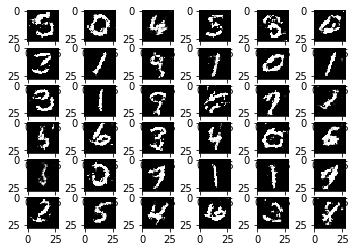

In [4]:
numberOfImagesToBeDisplayed=36
with torch.no_grad():   
  z = torch.rand(numberOfImagesToBeDisplayed, latentDim).to(device)  
  fakeInput = bestGenerator(z,manyGaussians=True)
  plt.figure()
  y=(fakeInput[:,0,:,:]*0.5+0.5).cpu().detach().numpy()
  for i in range(numberOfImagesToBeDisplayed):
    plt.subplot(numberOfImagesToBeDisplayed**0.5,numberOfImagesToBeDisplayed**0.5,i+1)
    plt.imshow(y[i], cm.gray, vmin=0, vmax=1)
    
plt.show()

In [0]:
with torch.no_grad():
            z = torch.randn(10000, latentDim).to(device)
            fakeInput = generator(z,manyGaussians = True)
            preds = torch.exp(MNISTclassifier(fakeInput)).detach().cpu().numpy()
            InceptionScores = calculateInceptionScore(preds)
            modifiedInceptionScores = calculateModifiedInceptionScore(preds)
            print(InceptionScores)
            print(modifiedInceptionScores)
#print(np.argmax(preds[0:100],axis=1))

[3.5593514, 3.548843, 3.6271281, 3.4673755, 3.5138748, 3.5173943, 3.6408625, 3.495318, 3.5248823, 3.4541626]
[5.514109, 10.468248, 11.057388, 12.940814, 13.018711, 7.547115, 7.803016, 5.368733, 2.2676222, 2.1165724]


In [0]:
with torch.no_grad():
            z = torch.randn(10000, latentDim).to(device)
            fakeInput = bestGenerator(z,manyGaussians = True)
            preds = torch.exp(MNISTclassifier(fakeInput)).detach().cpu().numpy()
            InceptionScores = calculateInceptionScore(preds)
            modifiedInceptionScores = calculateModifiedInceptionScore(preds)
            print(InceptionScores)
            print(modifiedInceptionScores)
#print(np.argmax(preds[0:100],axis=1))

NameError: ignored

In [0]:
chosenGaussian = nonUniformalRandomIntegers(weights=weightsOfGaussiansProbabilities,sizeOfOutput=1)
print(chosenGaussian)

[14.]
